# Gaussian Process Spectra in Python

### by Diego :)


In [1]:
%matplotlib inline
import numpy as np
import pandas as pd 
import seaborn as sns
import matplotlib.pylab as plt


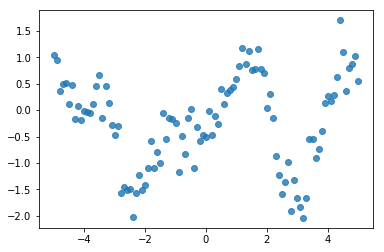

In [2]:
%run get_data.py
sns.regplot(x, y, fit_reg=False)

In [3]:
#Create new True objective Function y for our spaced values of x
# c = 0.3
# d = 0.3
# y = c*np.sin(x)**3# + d
# sns.regplot(x, y, fit_reg=False)

In [4]:
#Limit the number of Points from X
# x = x[0:101:10]
# y = y[0:101:10]
# # print x
# sns.regplot(x, y, fit_reg=False)

In [5]:
from sklearn import gaussian_process
from sklearn.gaussian_process.kernels import Matern, WhiteKernel, ConstantKernel, RBF, ExpSineSquared, RationalQuadratic, DotProduct

`scikit-learn` offers a library of about a dozen covariance functions, which they call *kernels*, to choose from. A flexible choice to start with is the Mat&#232;rn covariance. 

$$k_{M}(x) = \frac{\sigma^2}{\Gamma(\nu)2^{\nu-1}} \left(\frac{\sqrt{2 \nu} x}{l}\right)^{\nu} K_{\nu}\left(\frac{\sqrt{2 \nu} x}{l}\right)$$

where where $\Gamma$ is the gamma function and $K$ is a modified Bessel function. The form of covariance matrices sampled from this function is governed by three parameters, each of which controls a property of the covariance.

* **amplitude** ($\sigma$) controls the scaling of the output along the y-axis. This parameter is just a scalar multiplier, and is therefore usually left out of implementations of the Mat&#232;rn function (*i.e.* set to one)

* **lengthscale** ($l$) complements the amplitude by scaling realizations on the x-axis. Larger values make points appear closer together.

* **roughness** ($\nu$) controls the sharpness of ridges in the covariance function, which ultimately affect the roughness (smoothness) of realizations.

Though in general all the parameters are non-negative real-valued, when $\nu = p + 1/2$ for integer-valued $p$, the function can be expressed partly as a polynomial function of order $p$ and generates realizations that are $p$-times differentiable, so values $\nu \in \{3/2, 5/2\}$ are extremely common.

A GP kernel can be specified as the sum of additive components in `scikit-learn` simply by using the sum operator, so we can include a Mat&#232;rn component (`Matern`), an amplitude factor (`ConstantKernel`), as well as an observation noise (`WhiteKernel`):

In [35]:
kernel = WhiteKernel(noise_level=1) + RBF(length_scale=1.0, length_scale_bounds=(1e-05, 100000.0)) +ConstantKernel() + Matern(length_scale=2, nu=3/2)
X = x.reshape(-1, 1)
X.shape

(101, 1)

As mentioned, the `scikit-learn` API is very consistent across learning methods, and as a result, all functions expect a tabular set of input variables, either as a 2-dimensional NumPy `array` or a pandas `DataFrame`. Since we have only a single input variable here, we can add a second dimension using the `reshape` method:

Finally, we instantiate a `GaussianProcessRegressor` object with our custom kernel, and call its `fit` method, passing the input (`X`) and output (`y`) arrays.

In [38]:
#We need to edit this instance so that we don't just pass the kernel parameters and 
#generate the matrix & full inverse but go by our method
#I.E can we optimise even in one dimension using only some eigenvectors and eigenvalues

In [59]:
import matplotlib.pylab as plt
import matplotlib.mlab as mlab
from scipy.optimize import fmin_l_bfgs_b as minimize
#from scipy.optimize import minimize
def optimizernew(obj_func, initial_theta, bounds):
    # * 'obj_func' is the objective function to be maximized, which
    #   takes the hyperparameters theta as parameter and an
    #   optional flag eval_gradient, which determines if the
    #   gradient is returned additionally to the function value
    # * 'initial_theta': the initial value for theta, which can be
    #   used by local optimizers
    # * 'bounds': the bounds on the values of theta
    # Returned are the best found hyperparameters theta and
    # the corresponding value of the target function.de
    def print_coord(xk):
        #%run get_data.py
        #print("coordinates = %s" % np.array_str(xk))
        kernelfin = WhiteKernel(noise_level=np.exp(xk[0])) +  RBF(length_scale=np.exp(xk[1]), length_scale_bounds=(1e-05, 100000.0)) +ConstantKernel()*(np.exp(xk[2])) + Matern(length_scale=np.exp(xk[3]), nu=1)
        kf = kernelfin(X,X)
        eigs = np.linalg.eigvals(kf)
        #print eigs
        neweig = eigs/max(eigs)


        gmax = 1
        gmin = min(neweig)
        #gmin = min(eig)/max(eig)
        lines = 1e4+1
        #x = np.linspace(np.log(gmin), np.log(gmax), lines)
        #x = np.exp(x)

        x1 = np.linspace(gmin,gmax,lines)
        sharpness = (1e-4)
        #print 'creating y plot'
        y1 = 0;
        for i in range(0, len(neweig)):
            y1 = y1+(1/float(len(neweig)))*mlab.normpdf(x1, neweig[i], sharpness)

        titlespectra = 'Spectral Density of'+str(kernelfin.__dict__)

        line1, = plt.plot(x1,(y1), label="Gaussians")
        axes = plt.gca()

        #set log or normal plot
        axes.set_xlim([gmin,1])
        axes.set_xscale('log')
        #maxy = max([max(p),max(y1)])
        maxy = max([max(y1)])
        axes.set_ylim([0,maxy])
        plt.rcParams["figure.figsize"] = (10,10)
        first_legend = plt.legend(handles=[line1], loc=1)

        # Add the legend manually to the current Axes.
        ax = plt.gca().add_artist(first_legend)

        plt.title(titlespectra)
        plt.show()
        THETA = (xk[0],xk[1],xk[2],xk[3])
        print('Log Marginal Likelihood = '+str(gp.log_marginal_likelihood(theta=THETA, eval_gradient=False)))
        gp1 = gaussian_process.GaussianProcessRegressor(kernel=kernelfin)
        print(gp1)
        gp1.fit(X, y)
        #x_pred = np.linspace(-6, 6).reshape(-1,1)
        x_pred = x.reshape(-1,1)
        y_pred, sigma = gp1.predict(x_pred, return_std=True)
        print('RMSE = '+str(np.sqrt(sum((y-y_pred)**2/len(y)))))
        #print(y_pred)
        #print(gp1.predict(x_pred))
        plt.figure(figsize=(10,8))
        sns.regplot(x, y, fit_reg=False, label='Data')
        plt.plot(x_pred, y_pred, color='blue', label='Prediction')
        #c = 0.3
        #d = 0.3
        #xtruth = np.linspace(-6,6,101)
        #ytruth = c*np.sin(xtruth)**3
        #plt.plot(xtruth, ytruth, color='red', label='Truth')
        plt.fill(np.concatenate([x_pred, x_pred[::-1]]),
                 np.concatenate([y_pred - 2*sigma,
                                (y_pred + 2*sigma)[::-1]]),
                 alpha=.5, fc='grey', ec='None', label='95% CI')
        plt.xlabel('$x$')
        plt.ylabel('$f(x)$')
        plt.xlim(-6, 6)
        plt.ylim(-3, 3)
        plt.legend(loc='lower left');
        plt.show()
        
        
    theta_opt = minimize(obj_func, initial_theta, bounds=bounds, callback=print_coord)

#     import pdb; pdb.set_trace()
    #print(theta_opt[0])
    #print(theta_opt[1])

    return theta_opt[0], theta_opt[1], theta_opt[2], theta_opt[3]

/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:32: DeprecationWarning: object of type <type 'float'> cannot be safely interpreted as an integer.


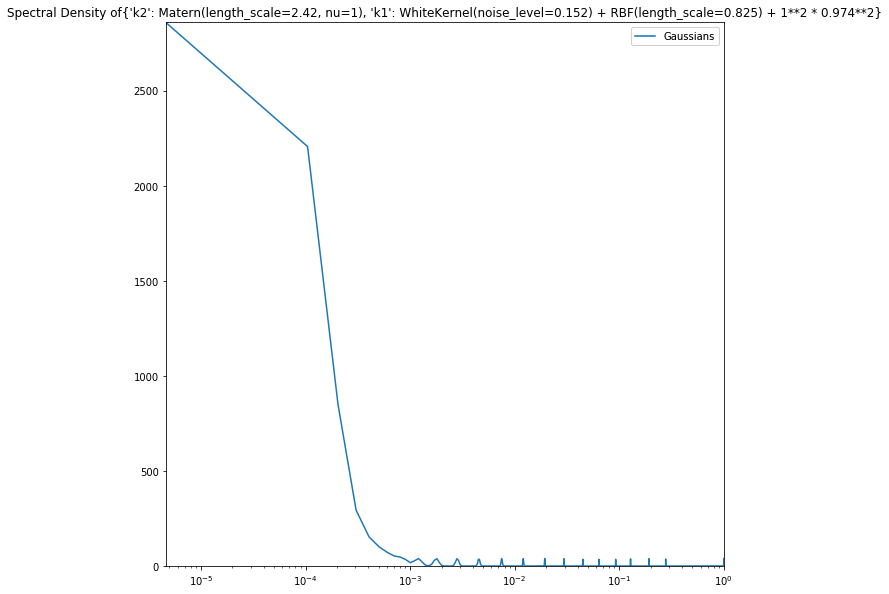

Log Marginal Likelihood = -57.5986302403
GaussianProcessRegressor(alpha=1e-10, copy_X_train=True,
             kernel=WhiteKernel(noise_level=0.152) + RBF(length_scale=0.825) + 1**2 * 0.974**2 + Matern(length_scale=2.42, nu=1),
             n_restarts_optimizer=0, normalize_y=False,
             optimizer='fmin_l_bfgs_b', random_state=None)
RMSE = 0.285077596338


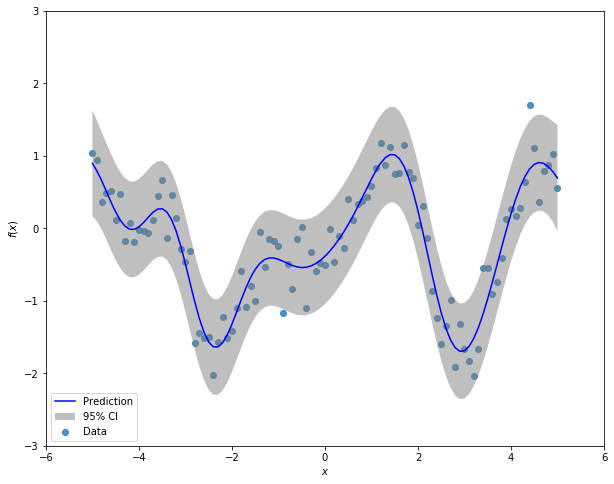

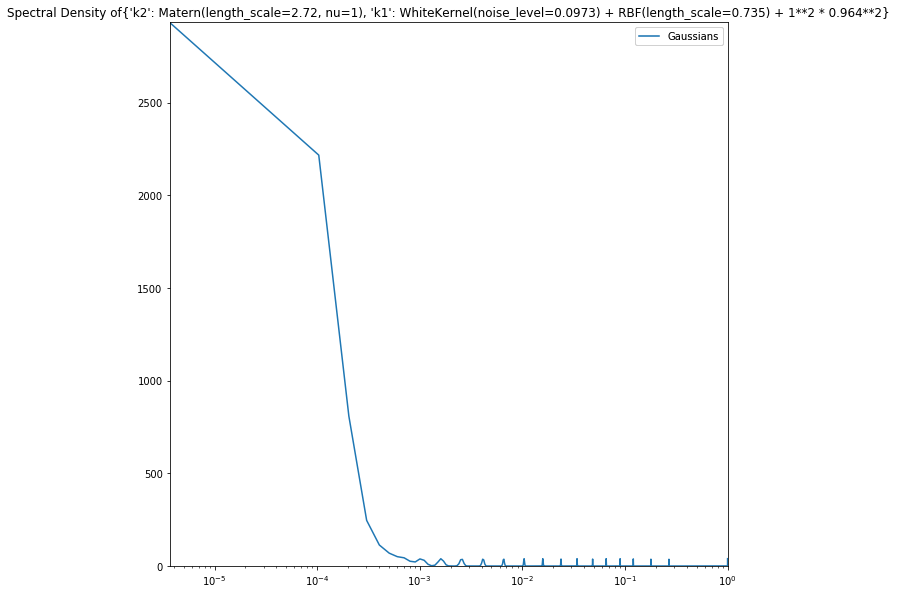

Log Marginal Likelihood = -53.0792368071
GaussianProcessRegressor(alpha=1e-10, copy_X_train=True,
             kernel=WhiteKernel(noise_level=0.0973) + RBF(length_scale=0.735) + 1**2 * 0.964**2 + Matern(length_scale=2.72, nu=1),
             n_restarts_optimizer=0, normalize_y=False,
             optimizer='fmin_l_bfgs_b', random_state=None)
RMSE = 0.285078200799


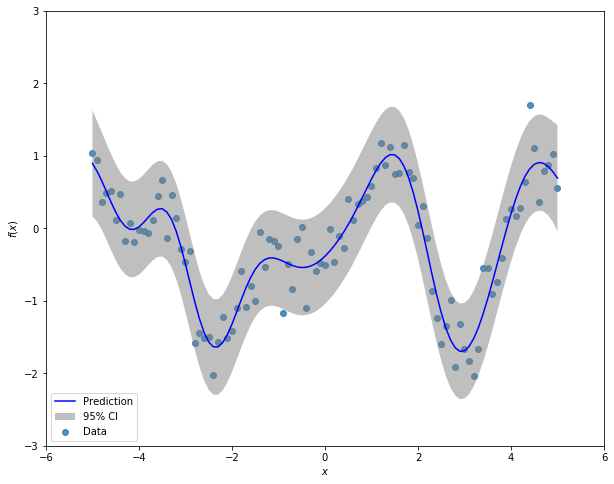

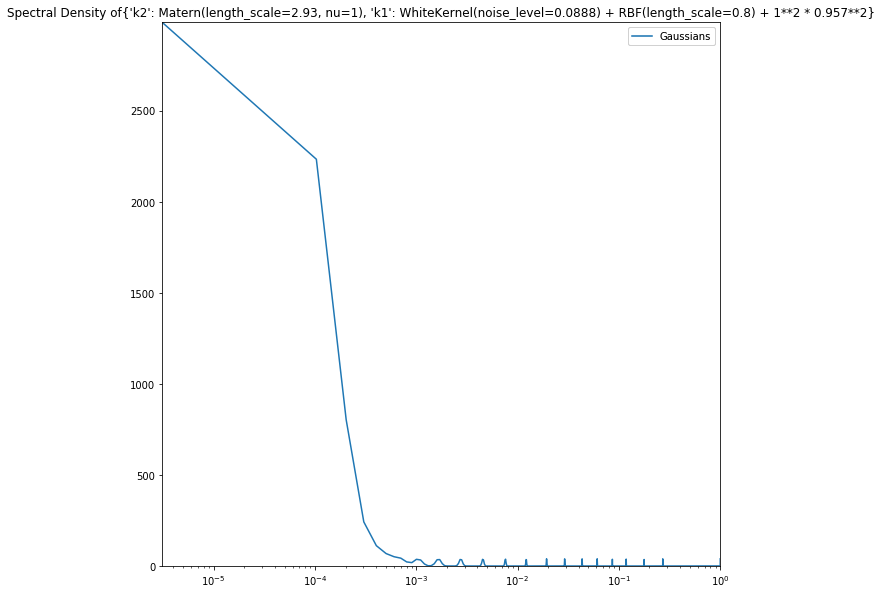

Log Marginal Likelihood = -52.9530597385
GaussianProcessRegressor(alpha=1e-10, copy_X_train=True,
             kernel=WhiteKernel(noise_level=0.0888) + RBF(length_scale=0.8) + 1**2 * 0.957**2 + Matern(length_scale=2.93, nu=1),
             n_restarts_optimizer=0, normalize_y=False,
             optimizer='fmin_l_bfgs_b', random_state=None)
RMSE = 0.285080121896


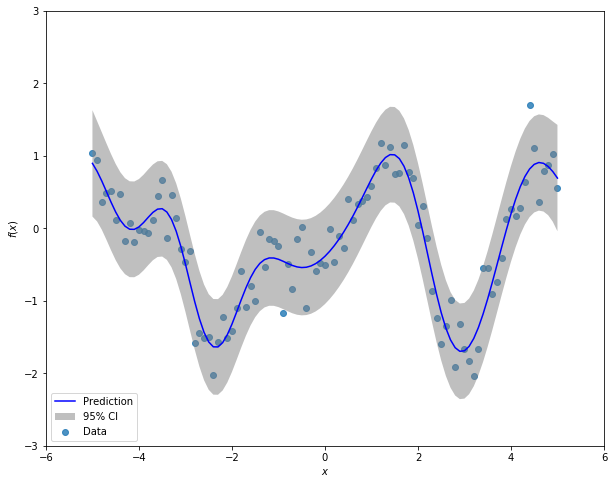

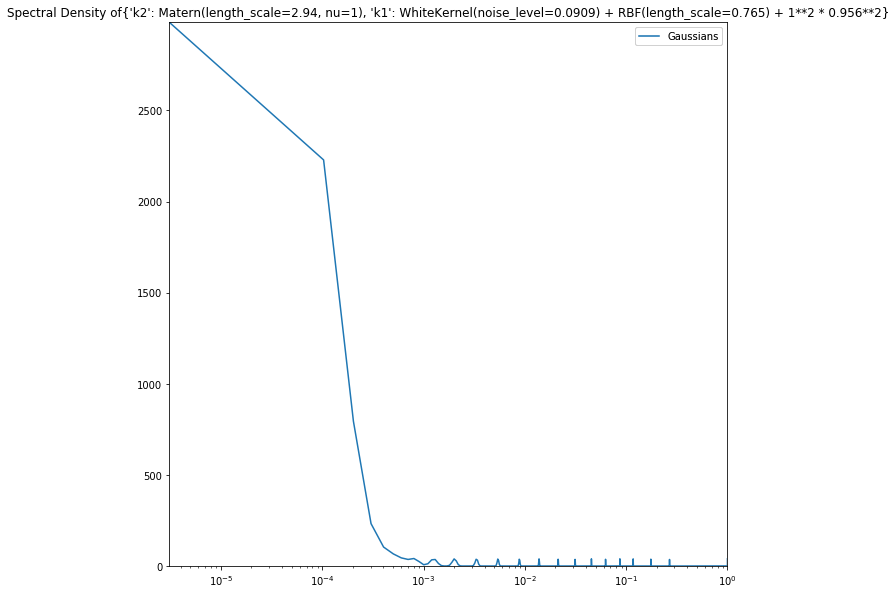

Log Marginal Likelihood = -52.8589566511
GaussianProcessRegressor(alpha=1e-10, copy_X_train=True,
             kernel=WhiteKernel(noise_level=0.0909) + RBF(length_scale=0.765) + 1**2 * 0.956**2 + Matern(length_scale=2.94, nu=1),
             n_restarts_optimizer=0, normalize_y=False,
             optimizer='fmin_l_bfgs_b', random_state=None)
RMSE = 0.285077745821


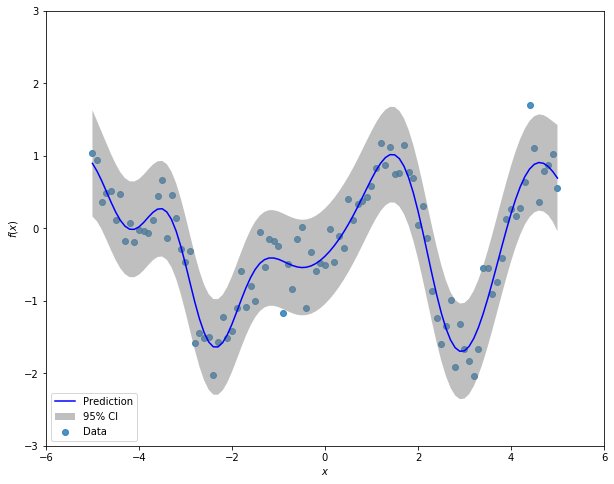

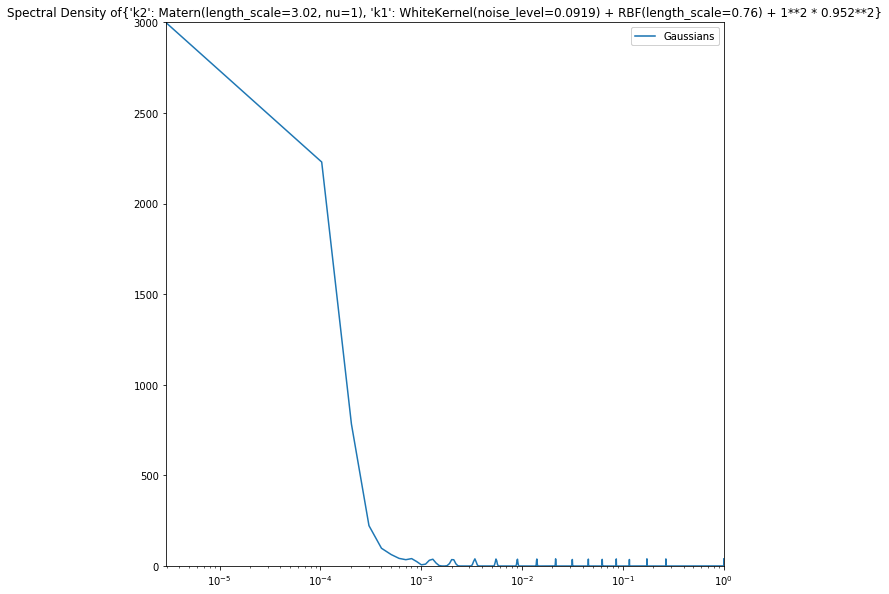

Log Marginal Likelihood = -52.8210690459
GaussianProcessRegressor(alpha=1e-10, copy_X_train=True,
             kernel=WhiteKernel(noise_level=0.0919) + RBF(length_scale=0.76) + 1**2 * 0.952**2 + Matern(length_scale=3.02, nu=1),
             n_restarts_optimizer=0, normalize_y=False,
             optimizer='fmin_l_bfgs_b', random_state=None)
RMSE = 0.285077490989


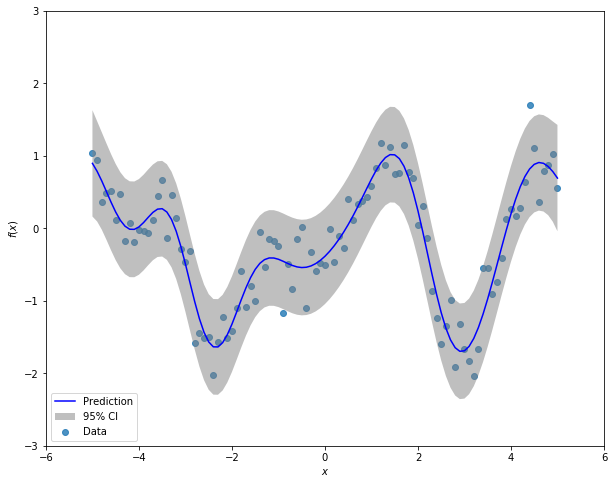

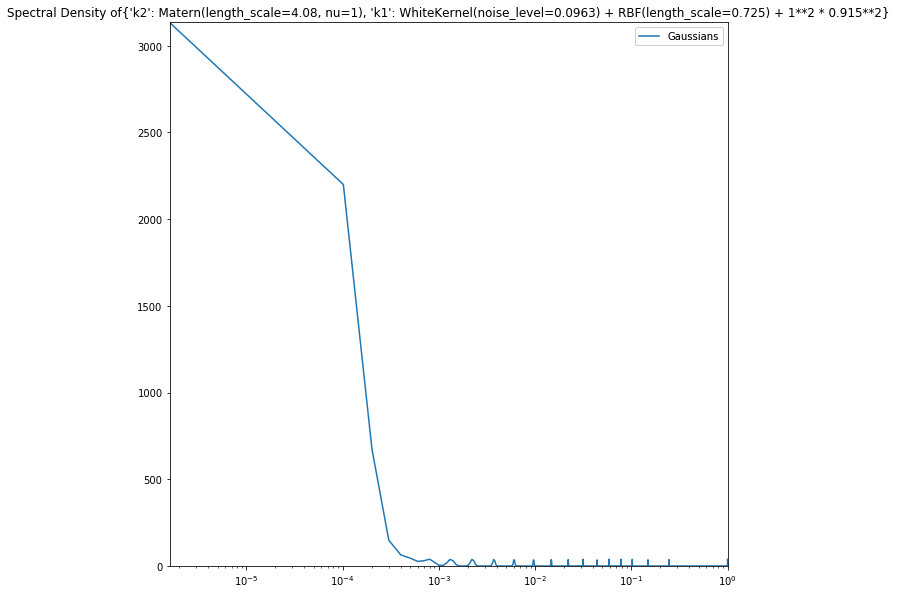

Log Marginal Likelihood = -52.5943941941
GaussianProcessRegressor(alpha=1e-10, copy_X_train=True,
             kernel=WhiteKernel(noise_level=0.0963) + RBF(length_scale=0.725) + 1**2 * 0.915**2 + Matern(length_scale=4.08, nu=1),
             n_restarts_optimizer=0, normalize_y=False,
             optimizer='fmin_l_bfgs_b', random_state=None)
RMSE = 0.28508406498


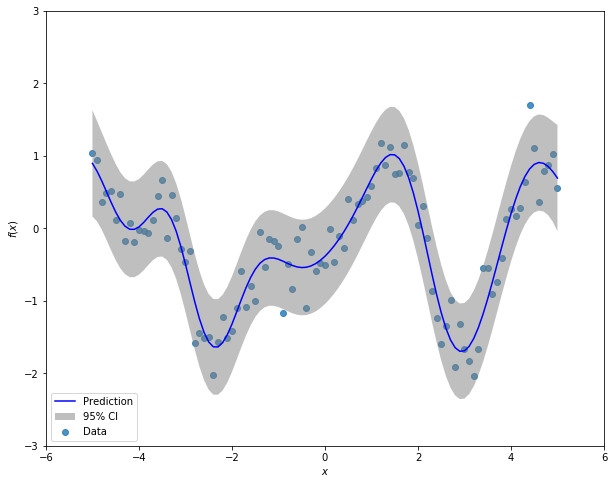

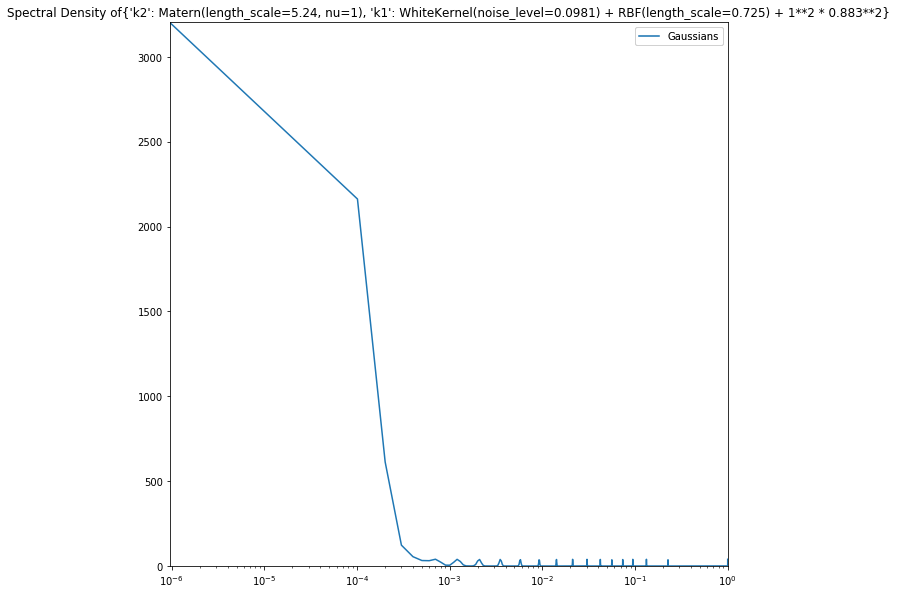

Log Marginal Likelihood = -52.429805175
GaussianProcessRegressor(alpha=1e-10, copy_X_train=True,
             kernel=WhiteKernel(noise_level=0.0981) + RBF(length_scale=0.725) + 1**2 * 0.883**2 + Matern(length_scale=5.24, nu=1),
             n_restarts_optimizer=0, normalize_y=False,
             optimizer='fmin_l_bfgs_b', random_state=None)
RMSE = 0.285077627273


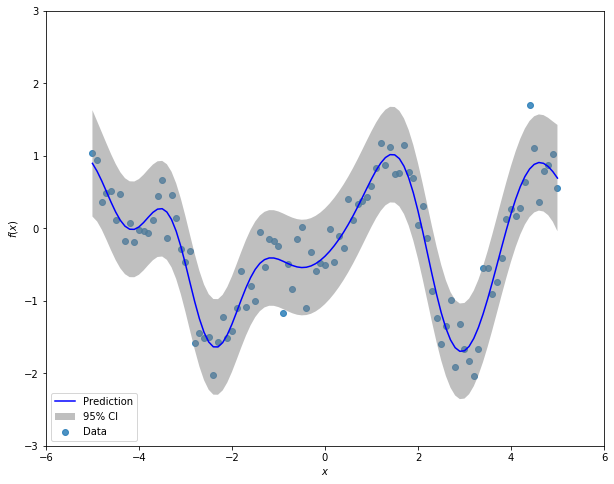

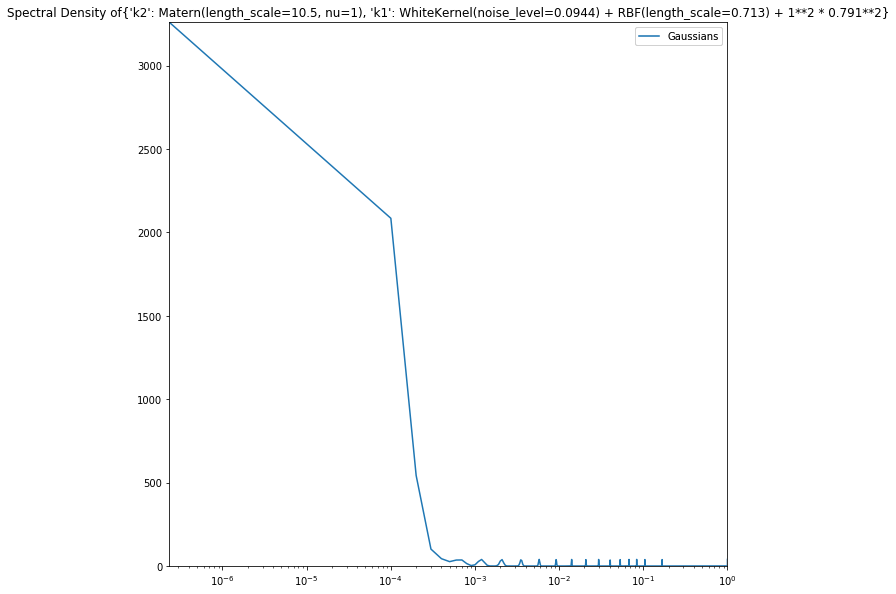

Log Marginal Likelihood = -52.101032522
GaussianProcessRegressor(alpha=1e-10, copy_X_train=True,
             kernel=WhiteKernel(noise_level=0.0944) + RBF(length_scale=0.713) + 1**2 * 0.791**2 + Matern(length_scale=10.5, nu=1),
             n_restarts_optimizer=0, normalize_y=False,
             optimizer='fmin_l_bfgs_b', random_state=None)
RMSE = 0.285081933077


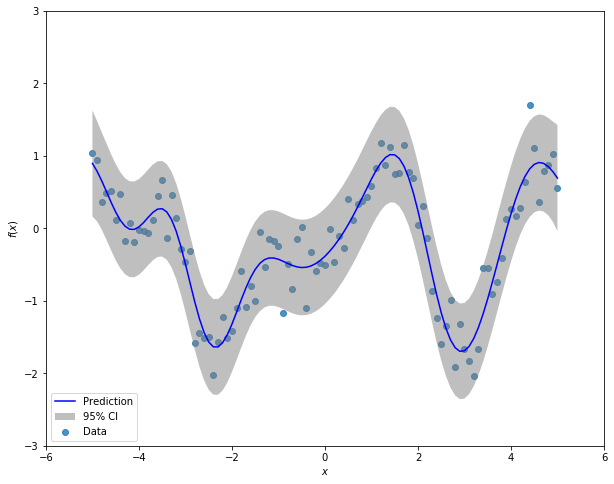

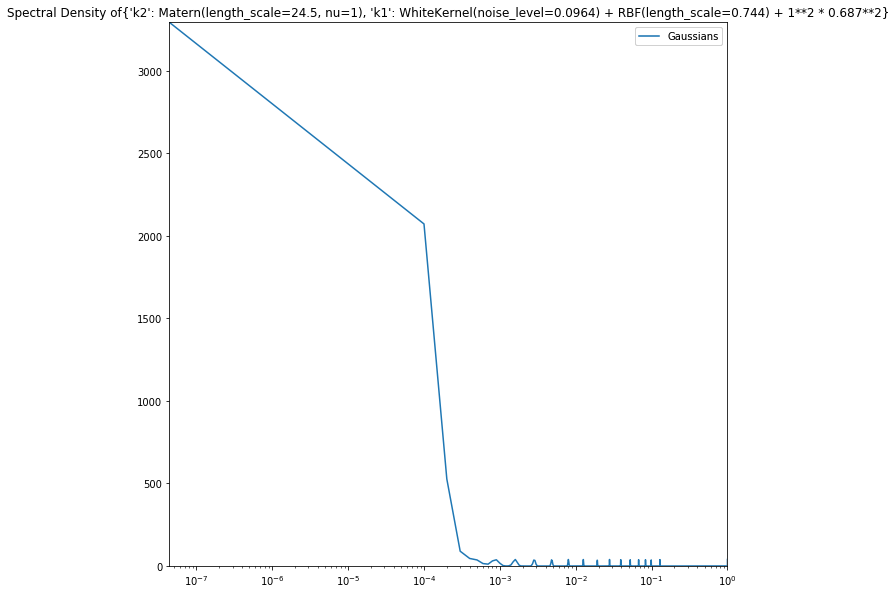

Log Marginal Likelihood = -51.8445326273
GaussianProcessRegressor(alpha=1e-10, copy_X_train=True,
             kernel=WhiteKernel(noise_level=0.0964) + RBF(length_scale=0.744) + 1**2 * 0.687**2 + Matern(length_scale=24.5, nu=1),
             n_restarts_optimizer=0, normalize_y=False,
             optimizer='fmin_l_bfgs_b', random_state=None)
RMSE = 0.285075004621


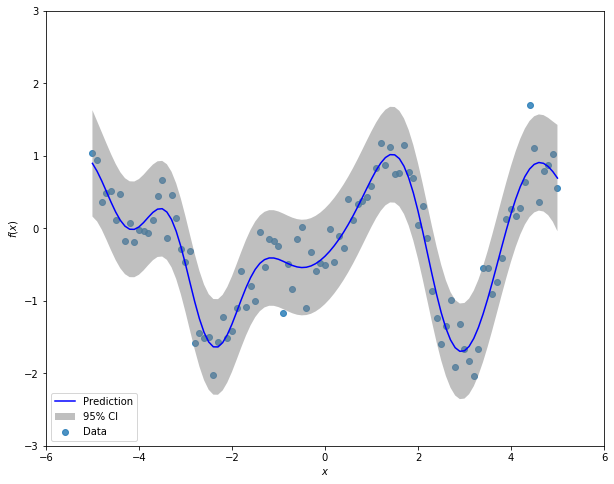

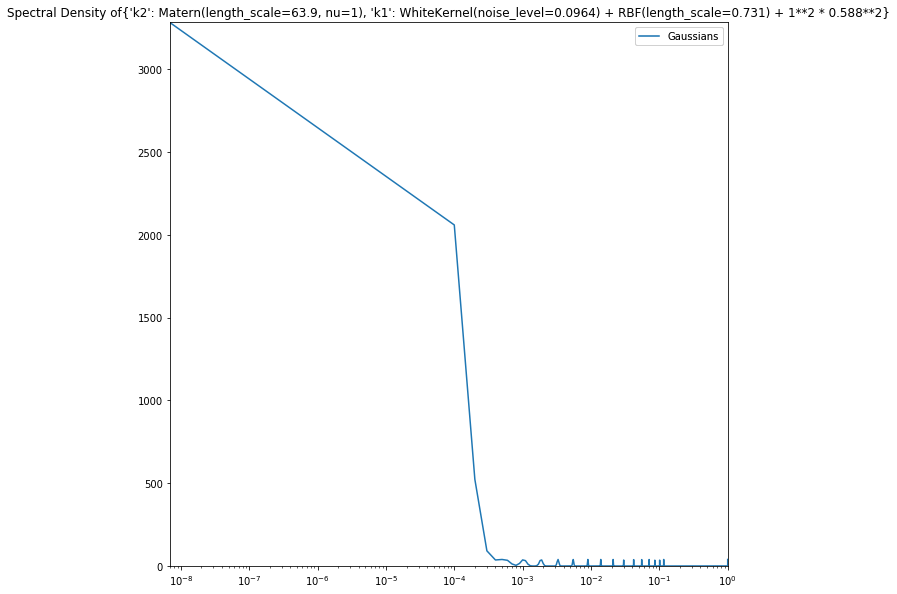

Log Marginal Likelihood = -51.6984569606
GaussianProcessRegressor(alpha=1e-10, copy_X_train=True,
             kernel=WhiteKernel(noise_level=0.0964) + RBF(length_scale=0.731) + 1**2 * 0.588**2 + Matern(length_scale=63.9, nu=1),
             n_restarts_optimizer=0, normalize_y=False,
             optimizer='fmin_l_bfgs_b', random_state=None)
RMSE = 0.285077255411


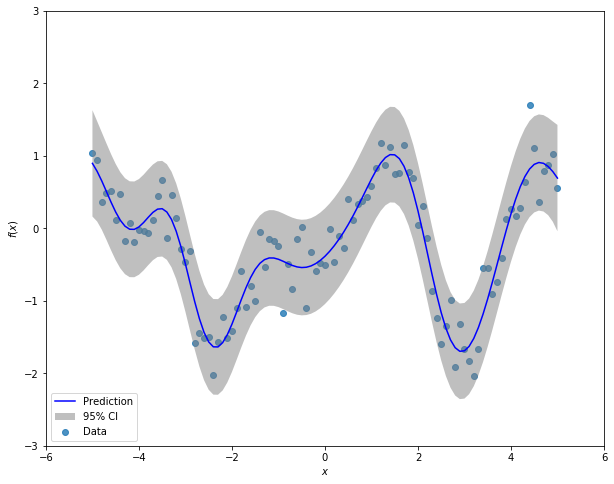

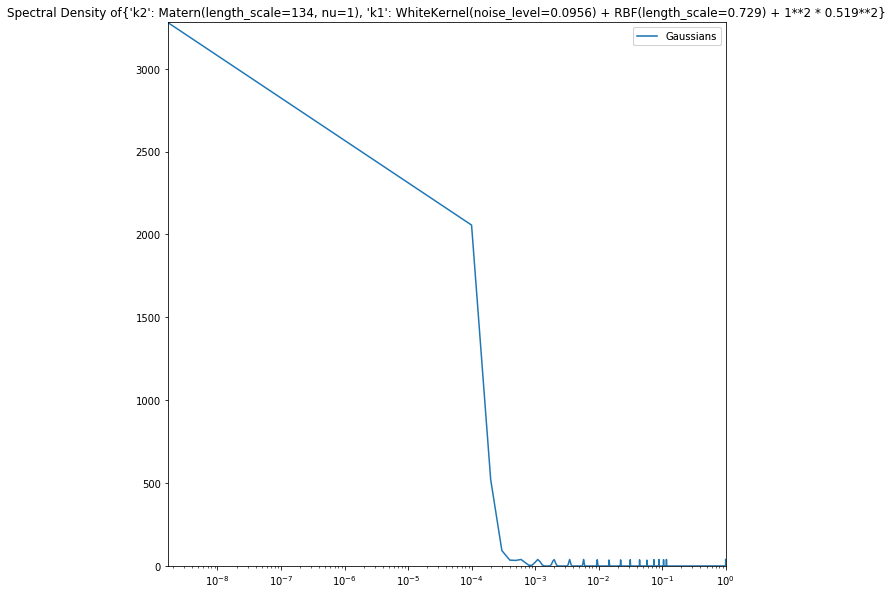

Log Marginal Likelihood = -51.6481463945
GaussianProcessRegressor(alpha=1e-10, copy_X_train=True,
             kernel=WhiteKernel(noise_level=0.0956) + RBF(length_scale=0.729) + 1**2 * 0.519**2 + Matern(length_scale=134, nu=1),
             n_restarts_optimizer=0, normalize_y=False,
             optimizer='fmin_l_bfgs_b', random_state=None)
RMSE = 0.285077391749


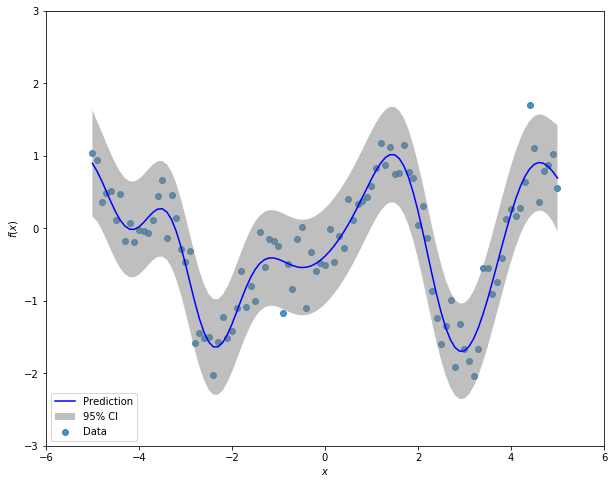

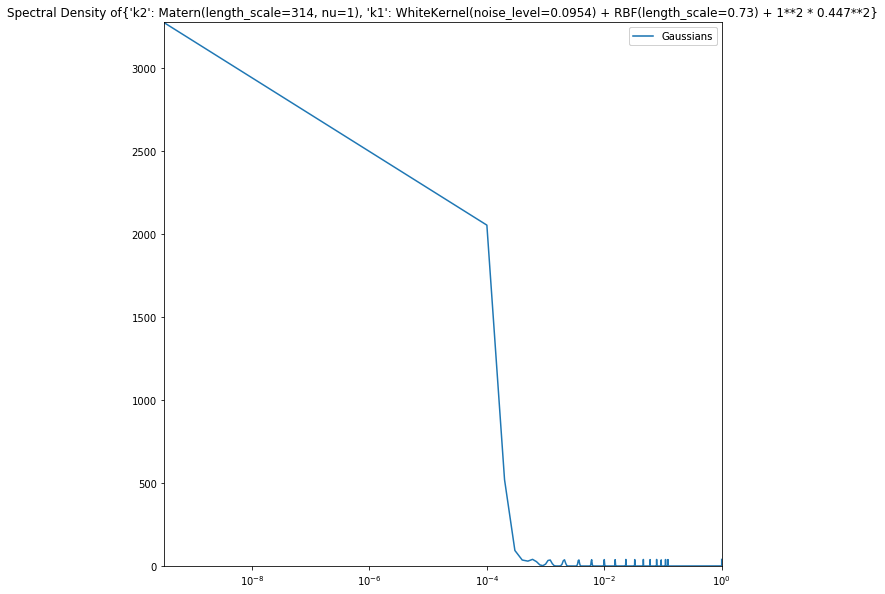

Log Marginal Likelihood = -51.6155652043
GaussianProcessRegressor(alpha=1e-10, copy_X_train=True,
             kernel=WhiteKernel(noise_level=0.0954) + RBF(length_scale=0.73) + 1**2 * 0.447**2 + Matern(length_scale=314, nu=1),
             n_restarts_optimizer=0, normalize_y=False,
             optimizer='fmin_l_bfgs_b', random_state=None)
RMSE = 0.285084463162


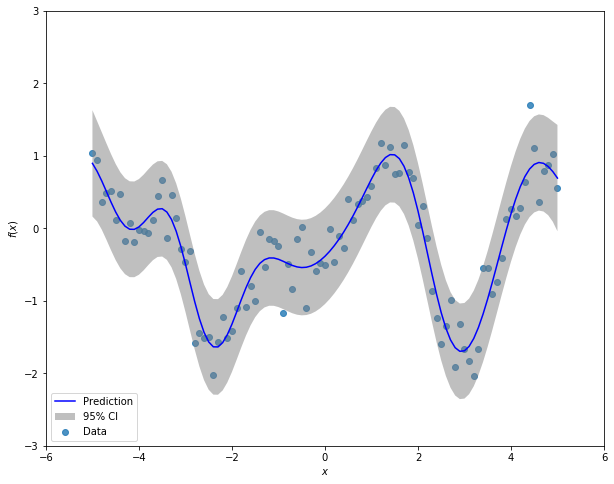

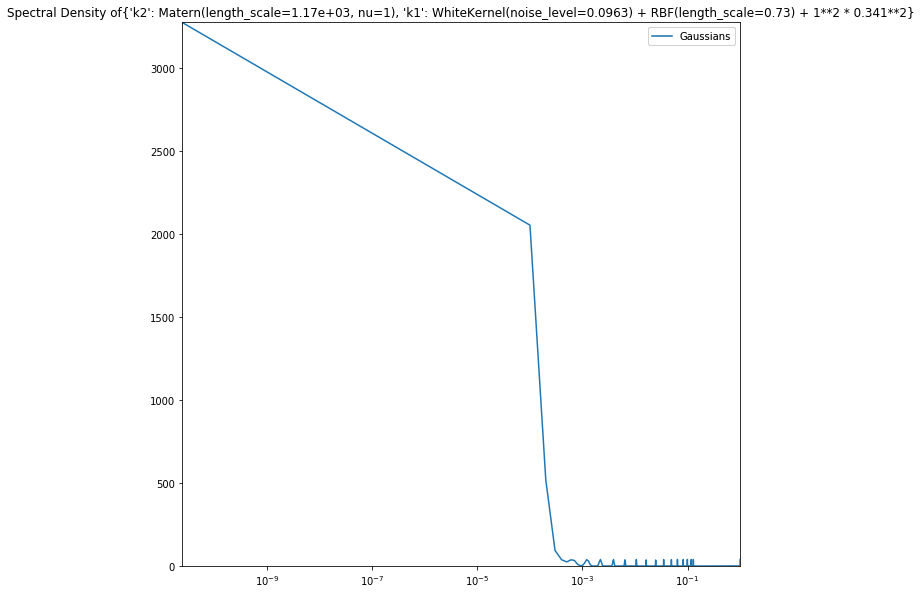

Log Marginal Likelihood = -51.5833838792
GaussianProcessRegressor(alpha=1e-10, copy_X_train=True,
             kernel=WhiteKernel(noise_level=0.0963) + RBF(length_scale=0.73) + 1**2 * 0.341**2 + Matern(length_scale=1.17e+03, nu=1),
             n_restarts_optimizer=0, normalize_y=False,
             optimizer='fmin_l_bfgs_b', random_state=None)
RMSE = 0.285077382664


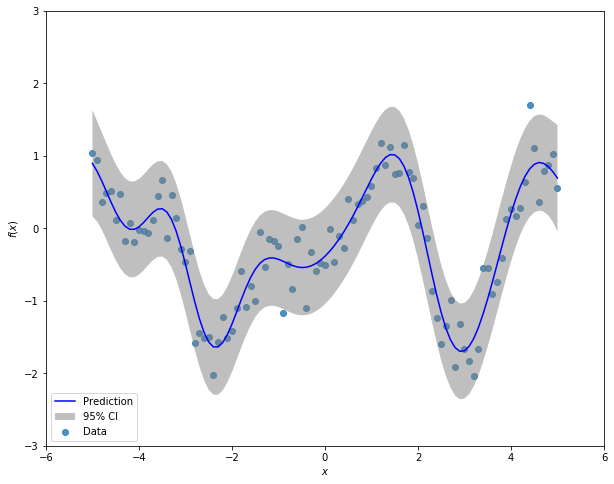

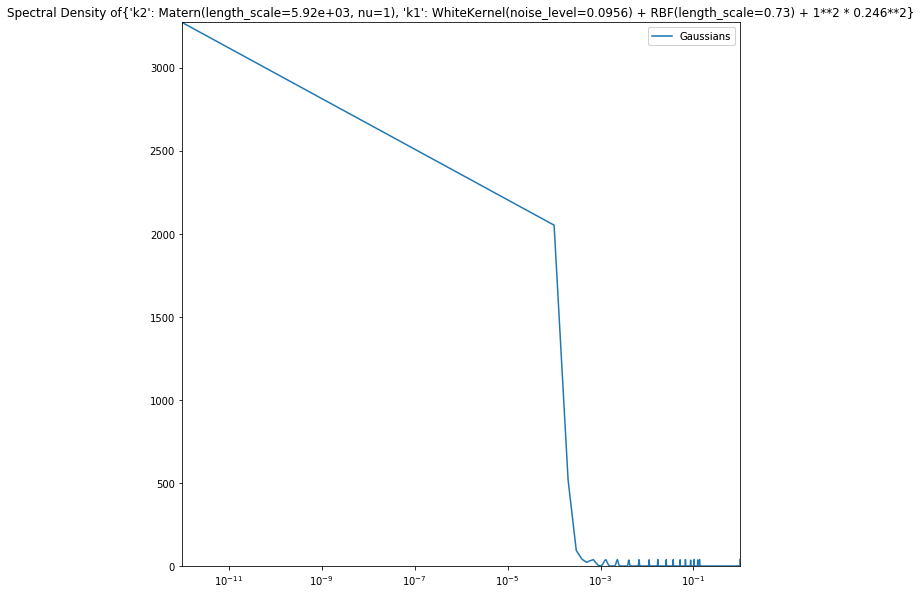

Log Marginal Likelihood = -51.5594461096
GaussianProcessRegressor(alpha=1e-10, copy_X_train=True,
             kernel=WhiteKernel(noise_level=0.0956) + RBF(length_scale=0.73) + 1**2 * 0.246**2 + Matern(length_scale=5.92e+03, nu=1),
             n_restarts_optimizer=0, normalize_y=False,
             optimizer='fmin_l_bfgs_b', random_state=None)
RMSE = 0.285076301536


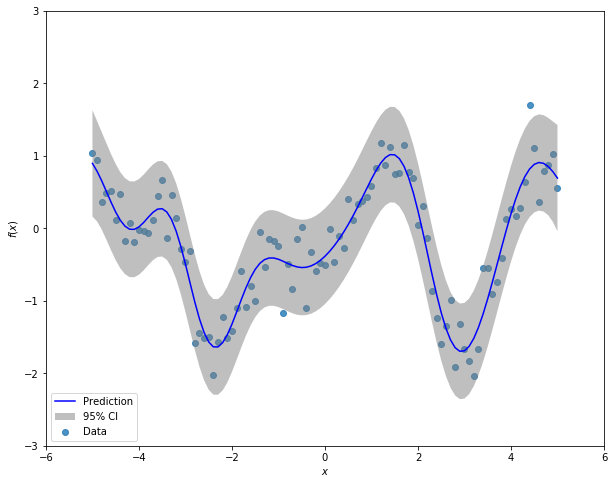

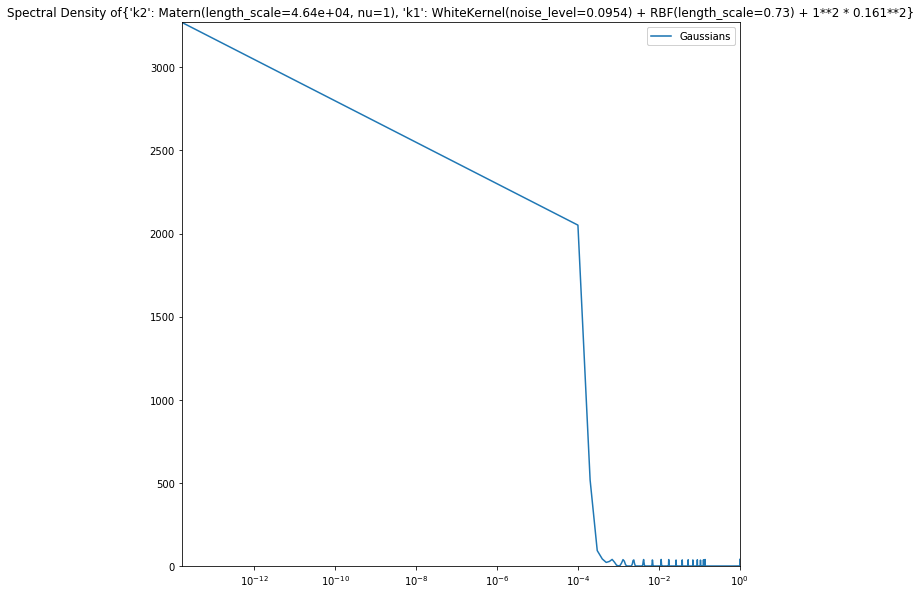

Log Marginal Likelihood = -51.5452670883
GaussianProcessRegressor(alpha=1e-10, copy_X_train=True,
             kernel=WhiteKernel(noise_level=0.0954) + RBF(length_scale=0.73) + 1**2 * 0.161**2 + Matern(length_scale=4.64e+04, nu=1),
             n_restarts_optimizer=0, normalize_y=False,
             optimizer='fmin_l_bfgs_b', random_state=None)
RMSE = 0.285075304868


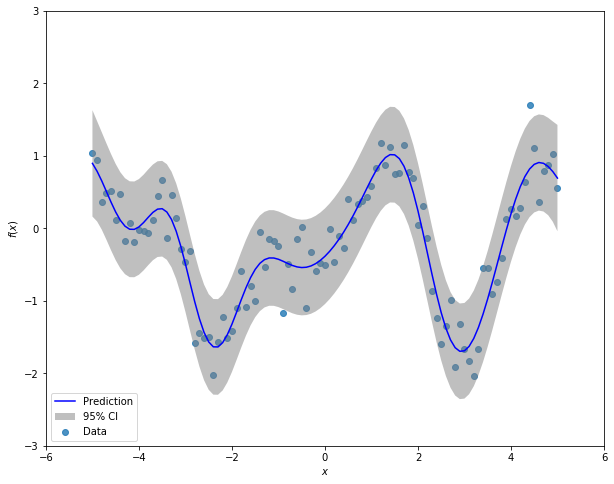

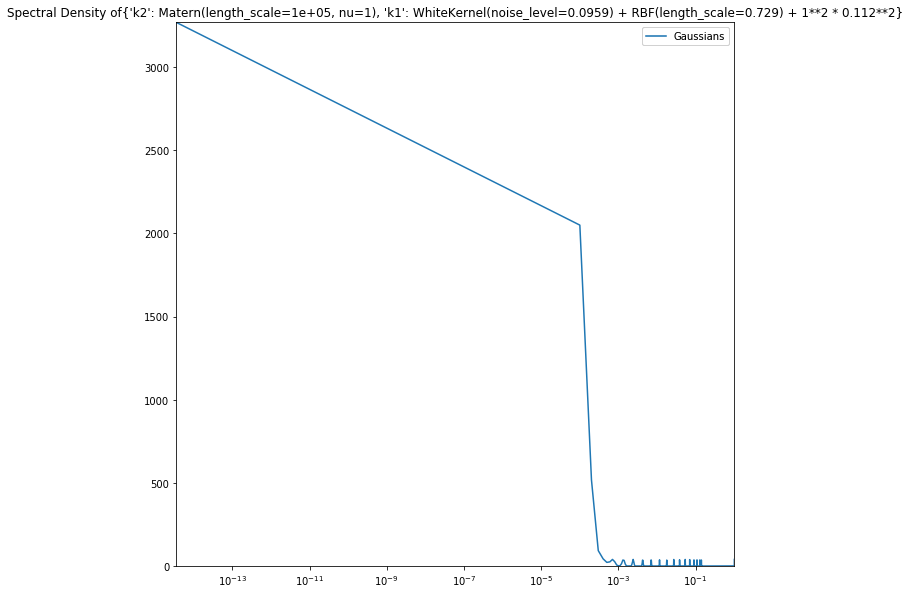

Log Marginal Likelihood = -51.5399632794
GaussianProcessRegressor(alpha=1e-10, copy_X_train=True,
             kernel=WhiteKernel(noise_level=0.0959) + RBF(length_scale=0.729) + 1**2 * 0.112**2 + Matern(length_scale=1e+05, nu=1),
             n_restarts_optimizer=0, normalize_y=False,
             optimizer='fmin_l_bfgs_b', random_state=None)
RMSE = 0.285077314865


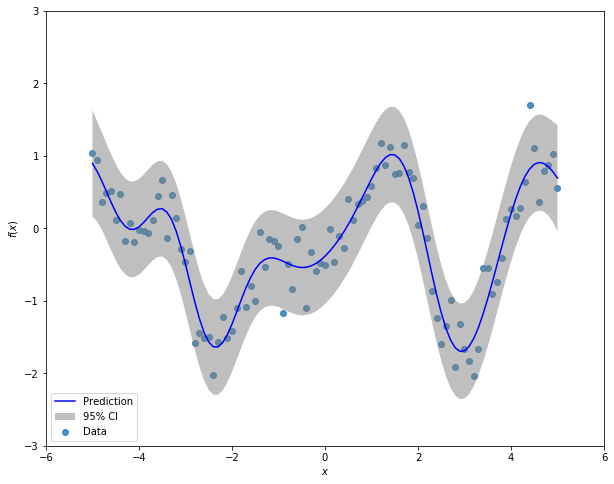

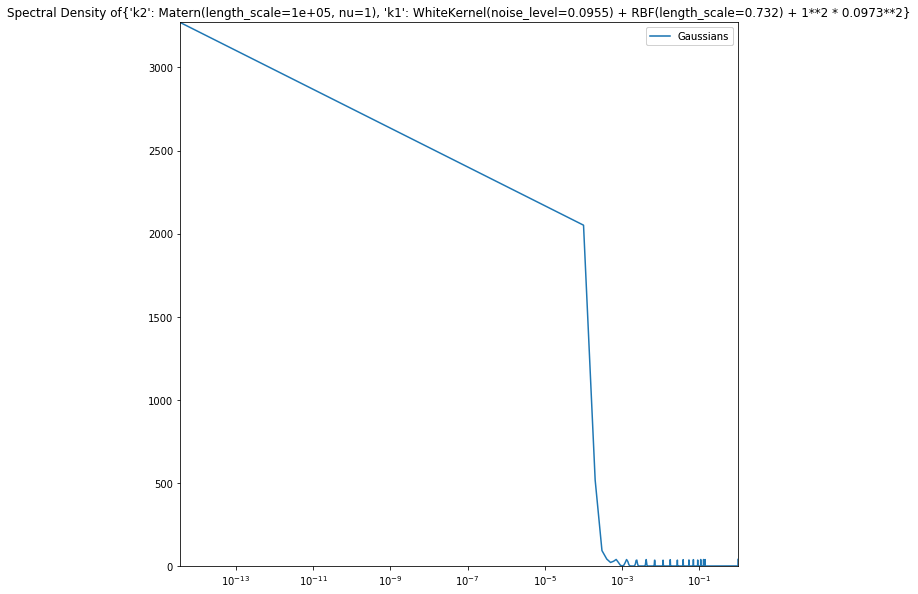

Log Marginal Likelihood = -51.5385256491
GaussianProcessRegressor(alpha=1e-10, copy_X_train=True,
             kernel=WhiteKernel(noise_level=0.0955) + RBF(length_scale=0.732) + 1**2 * 0.0973**2 + Matern(length_scale=1e+05, nu=1),
             n_restarts_optimizer=0, normalize_y=False,
             optimizer='fmin_l_bfgs_b', random_state=None)
RMSE = 0.285077668362


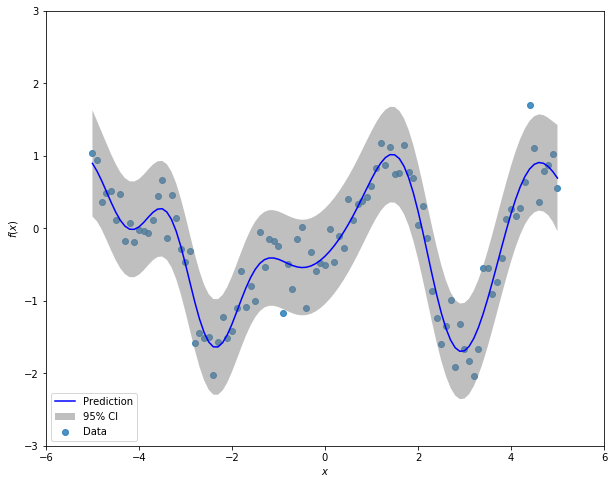

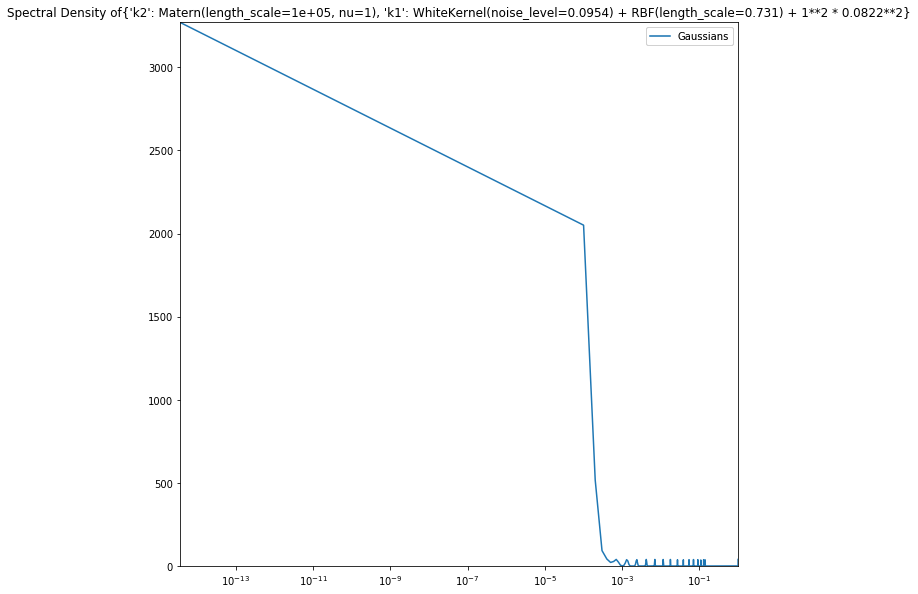

Log Marginal Likelihood = -51.5372333267
GaussianProcessRegressor(alpha=1e-10, copy_X_train=True,
             kernel=WhiteKernel(noise_level=0.0954) + RBF(length_scale=0.731) + 1**2 * 0.0822**2 + Matern(length_scale=1e+05, nu=1),
             n_restarts_optimizer=0, normalize_y=False,
             optimizer='fmin_l_bfgs_b', random_state=None)
RMSE = 0.285077197047


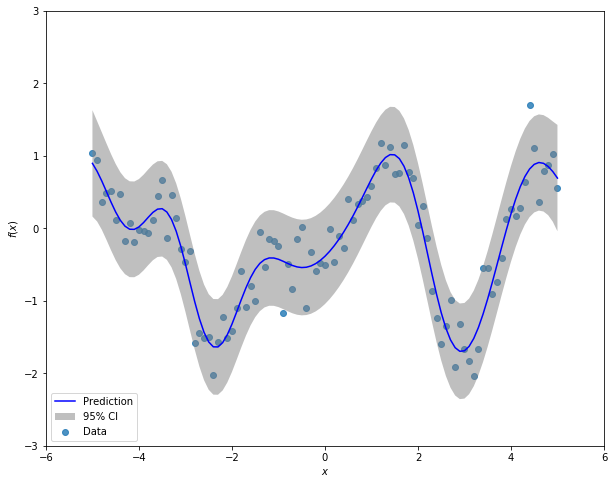

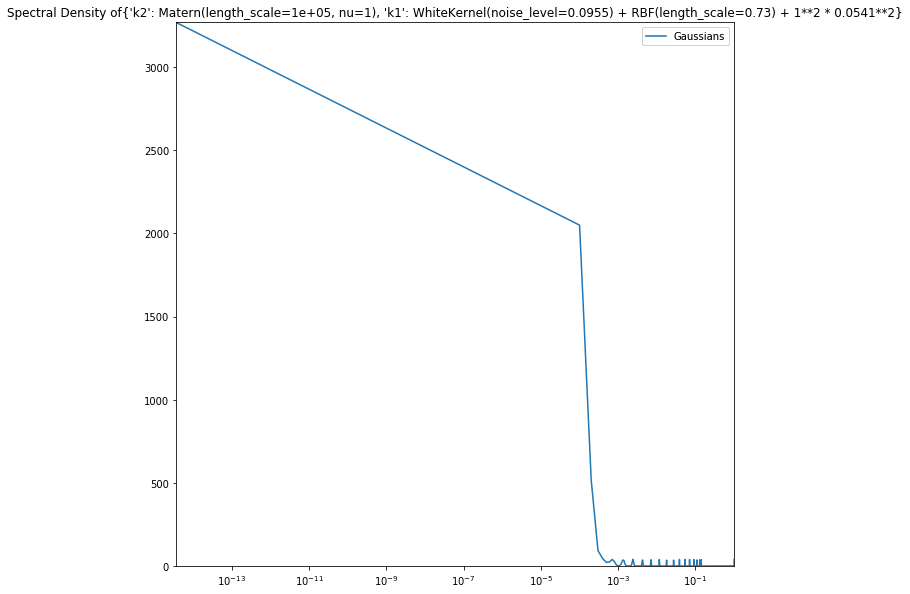

Log Marginal Likelihood = -51.5354757381
GaussianProcessRegressor(alpha=1e-10, copy_X_train=True,
             kernel=WhiteKernel(noise_level=0.0955) + RBF(length_scale=0.73) + 1**2 * 0.0541**2 + Matern(length_scale=1e+05, nu=1),
             n_restarts_optimizer=0, normalize_y=False,
             optimizer='fmin_l_bfgs_b', random_state=None)
RMSE = 0.285078309439


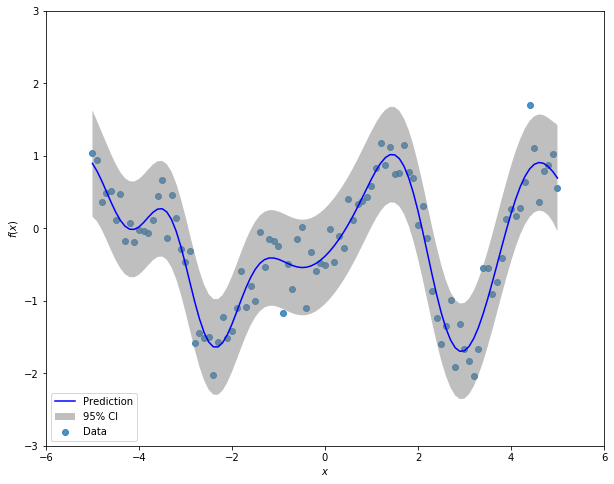

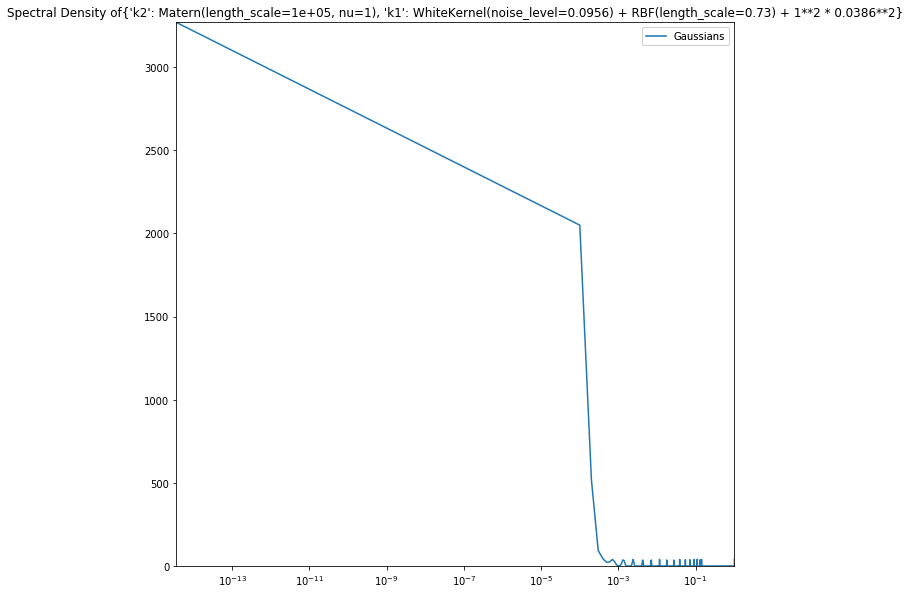

Log Marginal Likelihood = -51.5348881988
GaussianProcessRegressor(alpha=1e-10, copy_X_train=True,
             kernel=WhiteKernel(noise_level=0.0956) + RBF(length_scale=0.73) + 1**2 * 0.0386**2 + Matern(length_scale=1e+05, nu=1),
             n_restarts_optimizer=0, normalize_y=False,
             optimizer='fmin_l_bfgs_b', random_state=None)
RMSE = 0.285077492547


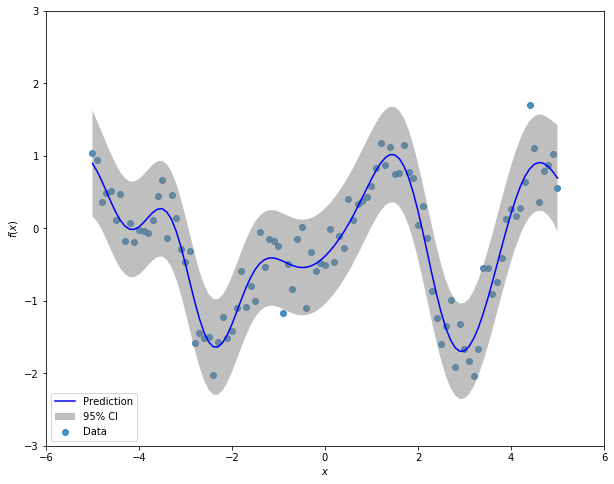

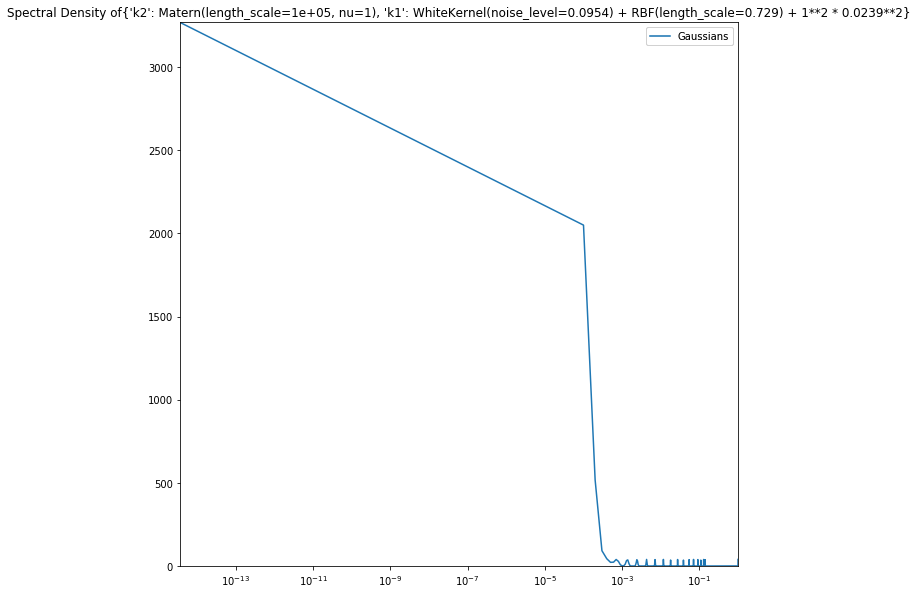

Log Marginal Likelihood = -51.5346028517
GaussianProcessRegressor(alpha=1e-10, copy_X_train=True,
             kernel=WhiteKernel(noise_level=0.0954) + RBF(length_scale=0.729) + 1**2 * 0.0239**2 + Matern(length_scale=1e+05, nu=1),
             n_restarts_optimizer=0, normalize_y=False,
             optimizer='fmin_l_bfgs_b', random_state=None)
RMSE = 0.285077584364


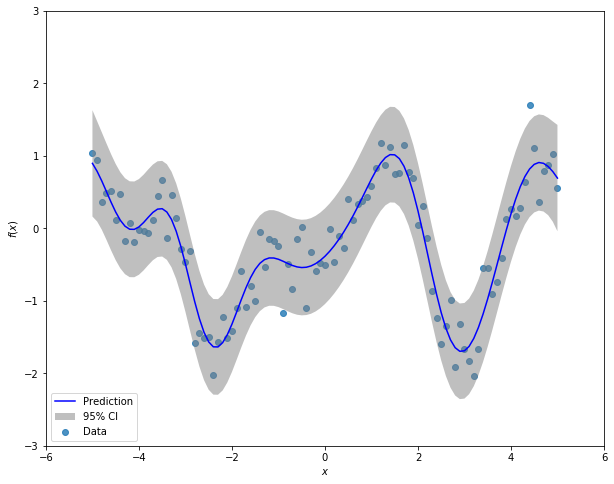

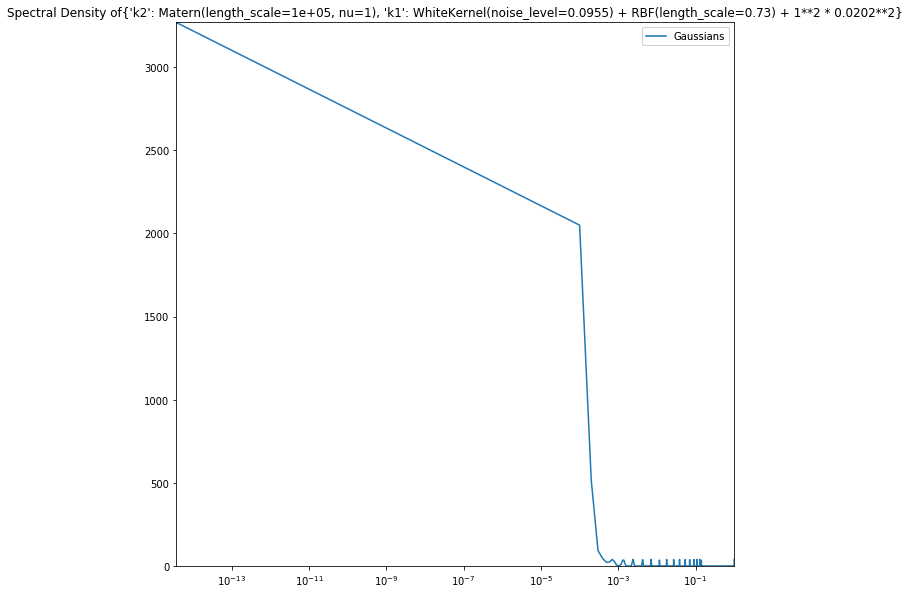

Log Marginal Likelihood = -51.5344017237
GaussianProcessRegressor(alpha=1e-10, copy_X_train=True,
             kernel=WhiteKernel(noise_level=0.0955) + RBF(length_scale=0.73) + 1**2 * 0.0202**2 + Matern(length_scale=1e+05, nu=1),
             n_restarts_optimizer=0, normalize_y=False,
             optimizer='fmin_l_bfgs_b', random_state=None)
RMSE = 0.285077440815


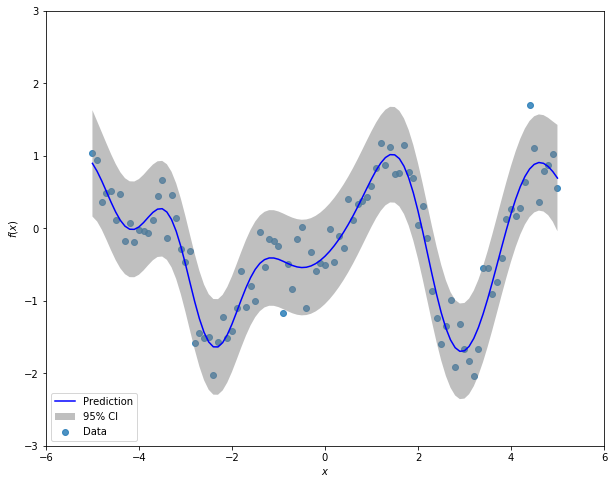

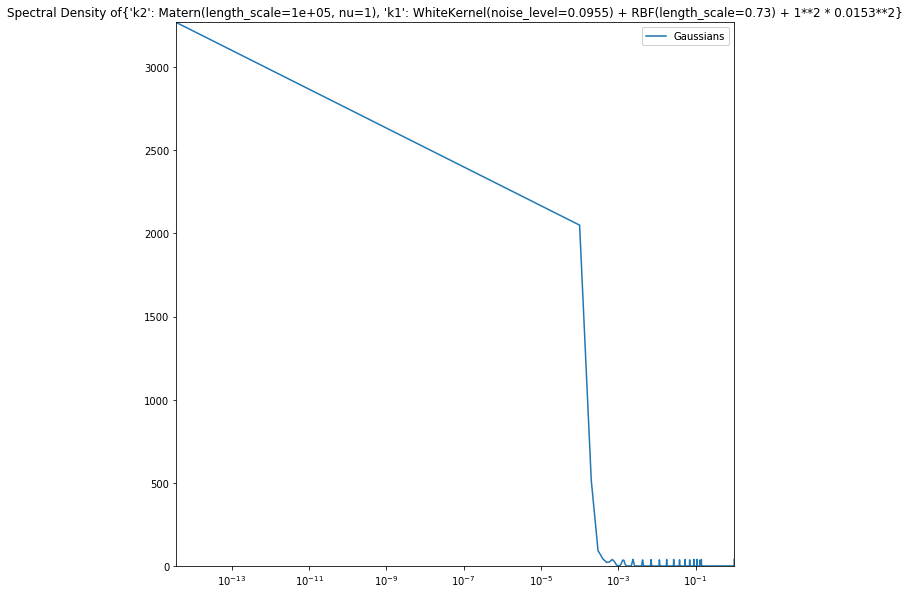

Log Marginal Likelihood = -51.5343208722
GaussianProcessRegressor(alpha=1e-10, copy_X_train=True,
             kernel=WhiteKernel(noise_level=0.0955) + RBF(length_scale=0.73) + 1**2 * 0.0153**2 + Matern(length_scale=1e+05, nu=1),
             n_restarts_optimizer=0, normalize_y=False,
             optimizer='fmin_l_bfgs_b', random_state=None)
RMSE = 0.285077486605


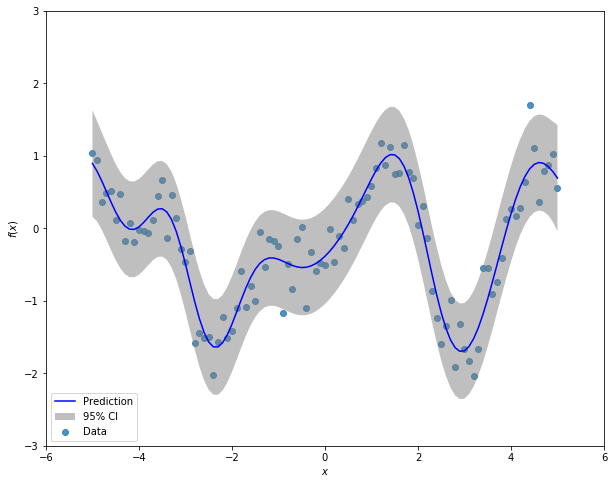

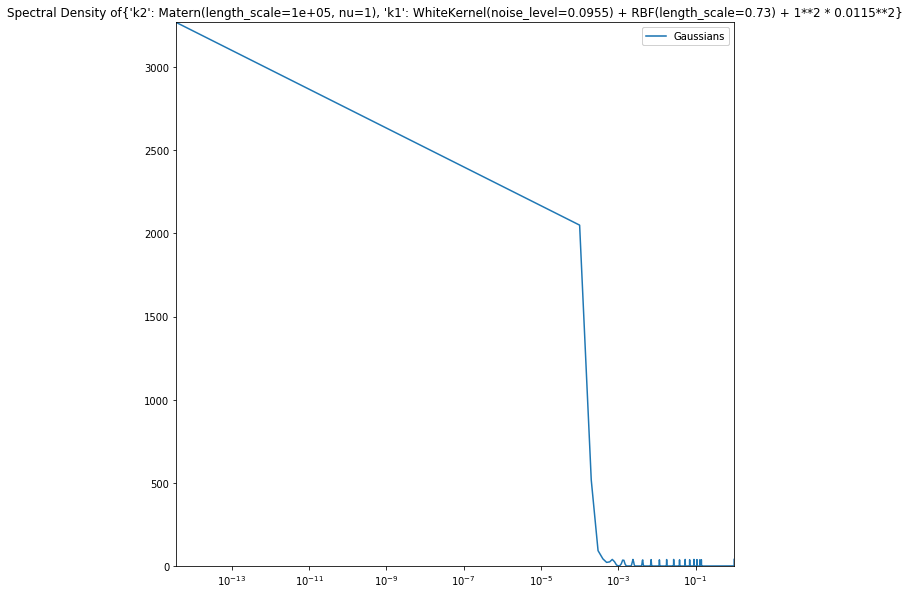

Log Marginal Likelihood = -51.5342781048
GaussianProcessRegressor(alpha=1e-10, copy_X_train=True,
             kernel=WhiteKernel(noise_level=0.0955) + RBF(length_scale=0.73) + 1**2 * 0.0115**2 + Matern(length_scale=1e+05, nu=1),
             n_restarts_optimizer=0, normalize_y=False,
             optimizer='fmin_l_bfgs_b', random_state=None)
RMSE = 0.285077493067


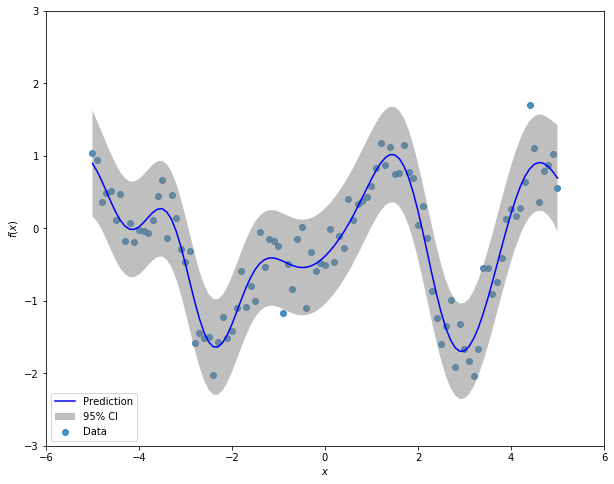

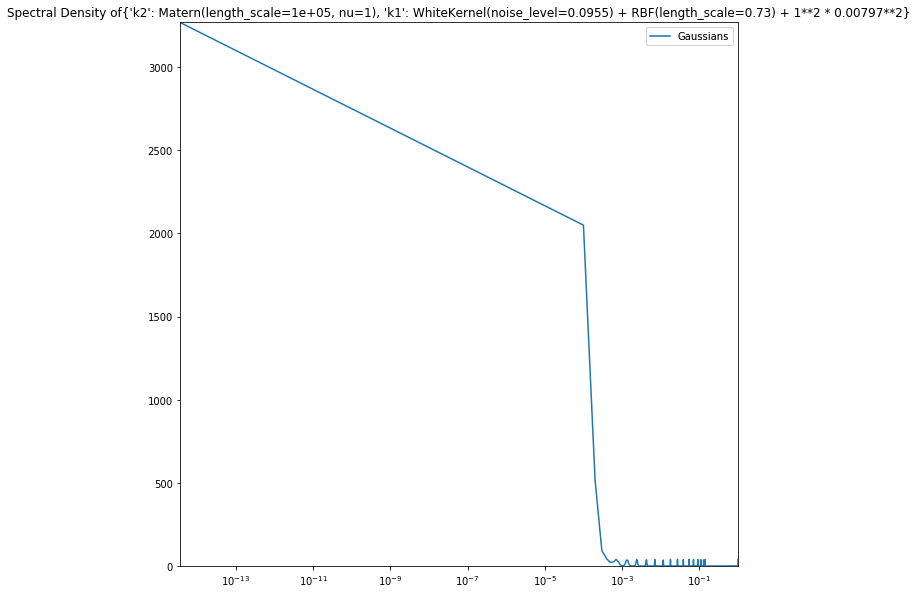

Log Marginal Likelihood = -51.5342464107
GaussianProcessRegressor(alpha=1e-10, copy_X_train=True,
             kernel=WhiteKernel(noise_level=0.0955) + RBF(length_scale=0.73) + 1**2 * 0.00797**2 + Matern(length_scale=1e+05, nu=1),
             n_restarts_optimizer=0, normalize_y=False,
             optimizer='fmin_l_bfgs_b', random_state=None)
RMSE = 0.28507743888


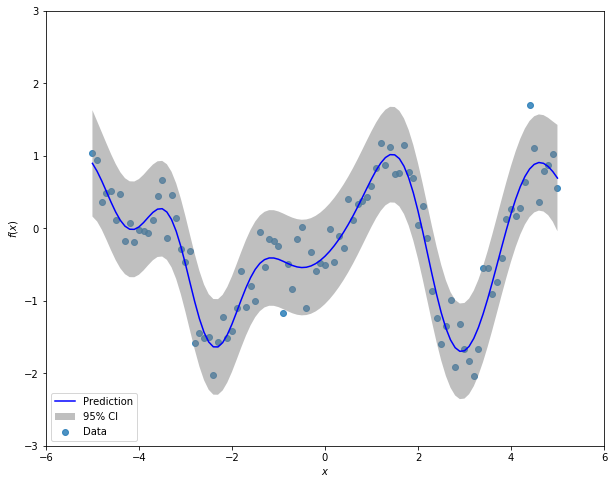

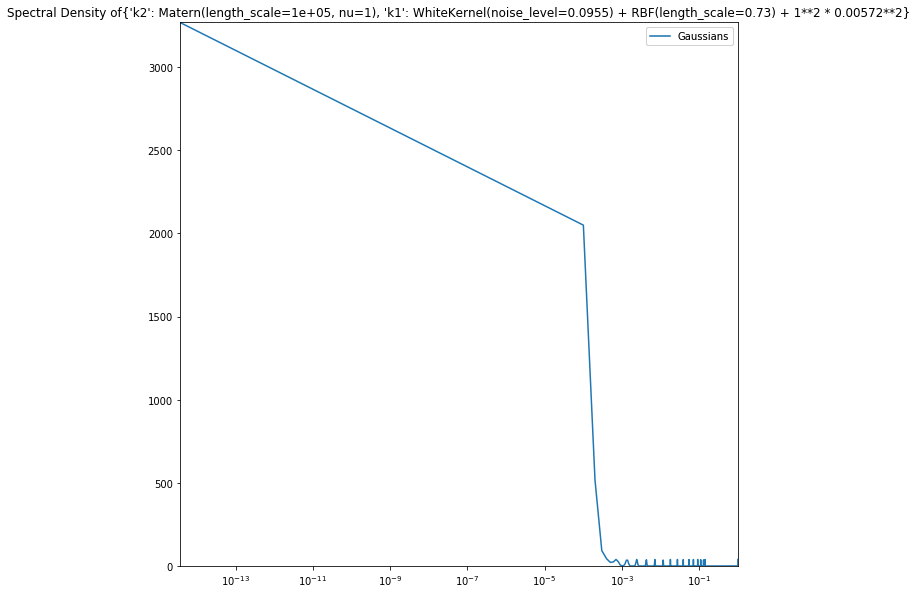

Log Marginal Likelihood = -51.5342330896
GaussianProcessRegressor(alpha=1e-10, copy_X_train=True,
             kernel=WhiteKernel(noise_level=0.0955) + RBF(length_scale=0.73) + 1**2 * 0.00572**2 + Matern(length_scale=1e+05, nu=1),
             n_restarts_optimizer=0, normalize_y=False,
             optimizer='fmin_l_bfgs_b', random_state=None)
RMSE = 0.285077494359


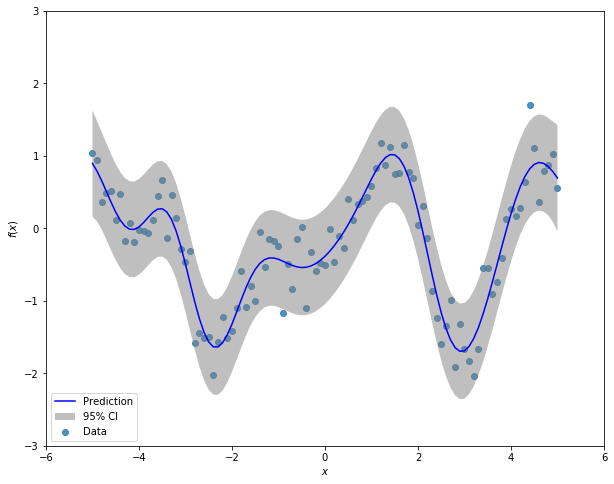

KeyboardInterrupt: 

In [61]:
gp = gaussian_process.GaussianProcessRegressor(kernel=kernel, optimizer=optimizernew)
gp.fit(X, y)

In [73]:
#Boston Housing Dataset
import pandas as pd
cd = 'train.csv'
train = pd.read_csv(cd)

from sklearn.cross_validation import train_test_split 
# TODO: Shuffle and split the data into training and testing subsets


#candidates = candidates.fillna(value='Null')
train.drop(['ID'],axis=1,inplace=True)
print(train.head())
tranx = train
trany = train
trany = (trany['medv'])
tranx.drop(['medv'], axis=1,inplace=True)
#tranx.head()

X_train, X_test, y_train, y_test = train_test_split(tranx, trany, test_size=0.1, random_state=None)

      crim    zn  indus  chas    nox     rm   age     dis  rad  tax  ptratio  \
0  0.00632  18.0   2.31     0  0.538  6.575  65.2  4.0900    1  296     15.3   
1  0.02731   0.0   7.07     0  0.469  6.421  78.9  4.9671    2  242     17.8   
2  0.03237   0.0   2.18     0  0.458  6.998  45.8  6.0622    3  222     18.7   
3  0.06905   0.0   2.18     0  0.458  7.147  54.2  6.0622    3  222     18.7   
4  0.08829  12.5   7.87     0  0.524  6.012  66.6  5.5605    5  311     15.2   

    black  lstat  medv  
0  396.90   4.98  24.0  
1  396.90   9.14  21.6  
2  394.63   2.94  33.4  
3  396.90   5.33  36.2  
4  395.60  12.43  22.9  


In [8]:
bound = []
startval = []
for i in range(0,(tranx.shape[1])):
    bound.append([1e-5,1e4])
    startval.append(1)
print(bound)
print(startval)

[[1e-05, 10000.0], [1e-05, 10000.0], [1e-05, 10000.0], [1e-05, 10000.0], [1e-05, 10000.0], [1e-05, 10000.0], [1e-05, 10000.0], [1e-05, 10000.0], [1e-05, 10000.0], [1e-05, 10000.0], [1e-05, 10000.0], [1e-05, 10000.0], [1e-05, 10000.0]]
[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


In [206]:
kernel = gaussian_process.kernels.RBF(startval, bound)
#kernel = WhiteKernel(noise_level=np.ones(tranx.shape[1]))  + Matern(length_scale=np.ones(tranx.shape[1]), nu=3/2)#+ConstantKernel(np.ones(tranx.shape[1]))

In [50]:
startval[1]

1

In [64]:
#Doesn't seem to work with WhiteKernel(noise_level=startval, noise_level_bounds=bounds)
kernel = DotProduct(sigma_0=1.0, sigma_0_bounds=(1e-05, 100000.0))+ConstantKernel(constant_value=startval[1], constant_value_bounds=bound[1])+WhiteKernel(noise_level=startval[1], noise_level_bounds=bound[1])+RBF(length_scale=startval, length_scale_bounds=bound) + Matern(length_scale=startval, length_scale_bounds=bound, nu=3/2)

In [79]:
kernel = RBF(length_scale=startval, length_scale_bounds=bound) + Matern(length_scale=startval, length_scale_bounds=bound, nu=3/2)

In [75]:
kernel(tranx.values,tranx.values)

array([[  2.00000000e+00,   7.09881002e-36,   5.51069054e-48, ...,
          1.94470140e-20,   1.11530301e-24,   2.43258047e-21],
       [  7.09881002e-36,   2.00000000e+00,   4.63881423e-24, ...,
          2.68001908e-19,   1.00116708e-20,   2.72178875e-19],
       [  5.51069054e-48,   4.63881423e-24,   2.00000000e+00, ...,
          4.14329704e-37,   4.45838251e-42,   2.28702339e-38],
       ..., 
       [  1.94470140e-20,   2.68001908e-19,   4.14329704e-37, ...,
          2.00000000e+00,   5.20130522e-09,   7.79974898e-03],
       [  1.11530301e-24,   1.00116708e-20,   4.45838251e-42, ...,
          5.20130522e-09,   2.00000000e+00,   1.78147743e-06],
       [  2.43258047e-21,   2.72178875e-19,   2.28702339e-38, ...,
          7.79974898e-03,   1.78147743e-06,   2.00000000e+00]])

In [80]:
#gp = gaussian_process.GaussianProcessRegressor(kernel=kernel, optimizer='fmin_l_bfgs_b')
gp = gaussian_process.GaussianProcessRegressor(kernel=kernel)
gp.fit(X_train,y_train)
print gp.kernel_

RBF(length_scale=[32.8, 1e+04, 1e+04, 1e+04, 1.35, 1.65, 1e+04, 21.2, 22.2, 1.68e+03, 13.5, 404, 12.2]) + Matern(length_scale=[0.19, 1.01, 0.000117, 2.21, 1e+04, 392, 1e+04, 1e+04, 3.67e-05, 1e-05, 0.00515, 0.000963, 2.28], nu=1)


In [81]:
#Prediction using GP and then compute mean square error
y_pred, sigma = gp.predict(X_test, return_std=True)
print np.sqrt(sum((y_pred-y_test)**2/len(X_test)))

5.34844324619


In [140]:
y_pred

array([ 16.97517735,  40.23537566,  16.2870513 ,  19.46784006,
        19.02157634,  17.64706772,   9.80878873,  34.98855747,
        18.73336407,  15.35360326,  17.14019935,  14.67164478,
        44.41852118,  25.60755649,  11.64123196,  24.8132045 ,
        38.0995791 ,  21.35433287,  19.69300926,  15.7773888 ,
        22.30512697,  20.99154621,  32.74077544,  34.3071628 ,
        22.45554258,  10.61935245,  13.64428047,  22.76285316,
        43.72593535,  27.90763778,  35.56262622,  32.4846238 ,
        20.00943356,  17.17138188])

In [125]:
y_test

311    13.8
109    50.0
101    15.4
327    18.3
328    17.5
211    17.8
283    12.8
187    35.4
30     19.4
248    13.8
90     18.4
323     8.1
141    48.5
182    25.2
247    13.8
191    22.0
178    36.5
69     18.6
304    19.9
299    16.4
1      21.6
219    19.8
173    42.8
226    32.7
149    23.3
274     8.3
330    20.6
76     18.5
160    48.3
203    28.4
135    36.4
177    31.0
104    17.0
310    23.2
Name: medv, dtype: float64